<a href="https://colab.research.google.com/github/sanjanahombal/Sentiment-Analysis-using-Neural-Networks/blob/main/SentimentAnalysisUsingNeuralNetworksWithKeras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### TODO Recording:

- Go to https://colab.research.google.com
- Sign in with the account
- Show that you are using the GPU runtime
- Open up the folder icon on the left
- Upload the Tweets.csv file to this folder

In [1]:
import re
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
import tensorflow as tf

from wordcloud import WordCloud
from tensorflow.keras import layers, models, losses, Sequential, optimizers, metrics

In [2]:
import tensorflow

print(tensorflow.__version__)

2.17.0


In [3]:
import keras

print(keras.__version__)

3.4.1


Upgrading seaborn to latest version

In [4]:
pip install seaborn -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 10.8 MB/s eta 0:00:00
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.13.1
    Uninstalling seaborn-0.13.1:
      Successfully uninstalled seaborn-0.13.1


In [5]:
import seaborn as sns

print(sns.__version__)

0.13.2


Loading the  data.
Dataset link-
https://www.kaggle.com/datasets/yasserh/twitter-tweets-sentiment-dataset/data?select=Tweets.csv

In [6]:
tweets_data = pd.read_csv("Tweets.csv")

tweets_data.sample(10)

,textID,text,selected_text,sentiment
22734,d1702a29a4,"got three grades so far: Math11 -> B , Acct1B ...","got three grades so far: Math11 -> B , Acct1B ...",neutral
25929,39af08ad27,Gotta get up early tomorrow...gotta be at work...,Gotta get up early tomorrow...gotta be at work...,neutral
10441,1fb2cc30c5,Notion video deleted.,Notion video deleted.,neutral
1862,e8afba201a,Kinda feeling in a reggae mood.... hope you al...,hope you all enjoy the smoothness on this love...,positive
16826,fbed853ab3,Lettuce & spinach does best in cool weather....,Lettuce & spinach does best in cool weather.. ...,neutral
21451,cbf297925a,"ermm, more like a full black upper half. and...","ermm, more like a full black upper half. and ...",neutral
19604,1324a81c00,"headache, headache, go away. come again anothe...","headache,",negative
19062,2cf37fe920,Missing how it used to be,Missing,negative
11586,cb4d3fa927,"blame it on the goose gotcha feelin loose, bla...","blame it on the goose gotcha feelin loose, bla...",neutral
18947,e12555fdc2,"Assfuck, 'I`m sorry' roll. Okay I gave in. I`...","Assfuck, 'I`m sorry' roll. Okay I gave in. I`...",negative


Dataset info is obtained

In [7]:
tweets_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


Null values are checked. Only one instance was found

In [8]:
tweets_data.isnull().sum()

,0
textID,0
text,1
selected_text,1
sentiment,0


Null value instance is dropped

In [9]:
tweets_data = tweets_data.dropna()

tweets_data.isnull().sum()

,0
textID,0
text,0
selected_text,0
sentiment,0


Duplicacy checked. None was found

In [10]:
tweets_data.duplicated().sum()

0

Dropping irrelevant columns

In [11]:
tweets_data = tweets_data.drop(columns = ["selected_text", "textID"])

tweets_data.sample(10)

,text,sentiment
21959,not goin tto tafe,neutral
15667,Hmmm.. If I skip the grocery store and head to...,neutral
14707,"browsing thru adopting agencies, i`m gonna get...",neutral
10233,I wish I was in va too,positive
15941,Definitely! I have usually found that critics...,negative
4010,Whaaaat a strong rain just came over us here i...,negative
11637,http://slingalink.com/eVicE1 my daughters kind...,neutral
12150,no the love of my life is. so i guess now im...,positive
1867,"awww, a very happy birthday to him",positive
10733,**** traffic. Going to be late!,negative


Target balance is checked

In [12]:
tweets_data["sentiment"].value_counts()

,count
sentiment,
neutral,11117
positive,8582
negative,7781


Neutral class counts is highest

<Axes: xlabel='sentiment', ylabel='count'>

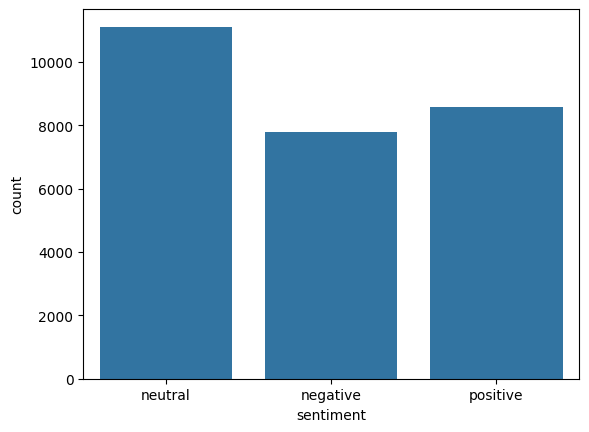

In [13]:
import seaborn as sns

sns.countplot(data = tweets_data, x = "sentiment")

Checking word counts for each instance of tweets

In [14]:
tweets_data["word_count"] = tweets_data["text"].apply(lambda x: len(str(x).split(" ")))

tweets_data[["text", "word_count"]].sample(10)

,text,word_count
1174,wants TFA back. http://plurk.com/p/x2rgl,5
5888,"well then you should come, nigguh. Only thing...",20
6000,any chance of seeing you at a race in germany...,22
9581,from here to cyborgs there`s but a small leap ...,12
12832,watching beauty & the beast haha,7
11292,_Guy Hello - iï¿½m back Hope that happens not...,14
7010,no room for me smh,7
17441,I KnO they`re my guilty pleasure like shopping,11
9979,yay cheerleading when im sick. its gonna be a ...,13
6253,He needs to go back to his Scotty. That is wh...,20


Mean word count is calculated for each class.Negative class word count mean is slightly higher.

In [15]:
tweets_data.groupby("sentiment")["word_count"].mean()

,word_count
sentiment,
negative,14.244313
neutral,13.207610
positive,14.100210


In [16]:
tweets_data.groupby("sentiment")["word_count"].median()

,word_count
sentiment,
negative,13.0
neutral,12.0
positive,13.0


Word count distribution is checked with histogram and boxplot and word count mean and median seems to be very close for all the classes

<Axes: xlabel='word_count', ylabel='Count'>

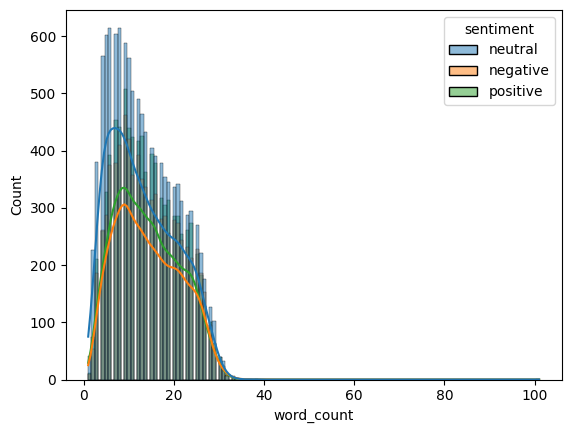

In [17]:
sns.histplot(data = tweets_data, x = "word_count", hue = "sentiment", kde = True)

<Axes: ylabel='word_count'>

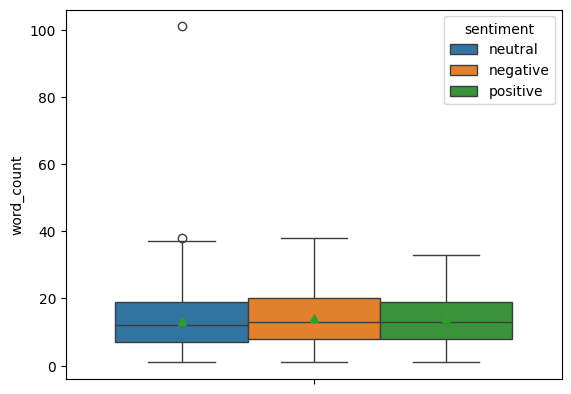

In [18]:
sns.boxplot(data = tweets_data, y = "word_count", hue = "sentiment", showmeans = True)

Downloading stopwords and viewing all the stop words

In [19]:
from nltk.corpus import stopwords

nltk.download("stopwords")

stop_words = stopwords.words("english")

print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [20]:
import string

def custom_standardization(input_data):

    # Convert to lowercase
    lowercase = tf.strings.lower(input_data)

    # Remove URLs
    stripped_urls = tf.strings.regex_replace(lowercase, r"https?://\S+|www\.\S+", "")

    # Remove email addresses
    stripped_symbol = tf.strings.regex_replace(stripped_urls, "\S*@\S*\s?", "")

    # Remove text in angular brackets (usually HTML tags)
    stripped_brackets = tf.strings.regex_replace(stripped_symbol, "<.*?>+", "")

    # Remove any square brackets and leave the text within square brackets
    stripped_brackets = tf.strings.regex_replace(stripped_brackets, "\[|\]", "")

    # Matches alphanumeric characters with digits and remove those
    stripped_digits = tf.strings.regex_replace(stripped_brackets, "\w*\d\w*", "")

    # Remove stopwords
    stripped_stopwords = tf.strings.regex_replace(stripped_digits, r"\b(?:{})\b".format("|".join(stop_words)), "")

    # Replace multiple whitespaces with a single whitespace
    stripped_whitespace_chars = tf.strings.regex_replace(stripped_stopwords, "\s+", " ")

    # Remove non-alphabet characters
    return tf.strings.regex_replace(stripped_whitespace_chars ,r"[^a-zA-Z\s]+" ,"")

few texts are cleaned using the clean_text function..url is removed here. Stopwords are removed in all cases below

In [21]:
tweets_data["text"][5]

'http://www.dothebouncy.com/smf - some shameless plugging for the best Rangers forum on earth'

In [22]:
custom_standardization(tweets_data["text"][5]).numpy()

b'  shameless plugging best rangers forum earth'

Digits , brackets, punctuations, stopwords are removed

In [23]:
tweets_data["text"][20]

' oh Marly, I`m so sorry!!  I hope you find her soon!! <3 <3'

In [24]:
custom_standardization(tweets_data["text"][20]).numpy()

b' oh marly  sorry hope find soon  '

@ symbol is removed

In [25]:
tweets_data["text"][527]

'i am living in ignorance  :@'

In [26]:
custom_standardization(tweets_data["text"][527]).numpy()

b' living ignorance '

Brackets with enclosed text and url is removed

In [27]:
tweets_data["text"][11827]

'My Degree  [Tear] happy moment!  http://mypict.me/1ZpF'

In [28]:
custom_standardization(tweets_data["text"][11827]).numpy()

b' degree tear happy moment '

Now we are cleaning messages by applying  custom standardization. This steps are for visualising word cloud and  not required for classification task

In [29]:
tweets_data["cleaned_text"] = tweets_data["text"].apply(custom_standardization)

tweets_data

,text,sentiment,word_count,cleaned_text
0,"I`d have responded, if I were going",neutral,8,"tf.Tensor(b' responded going', shape=(), dtyp..."
1,Sooo SAD I will miss you here in San Diego!!!,negative,11,"tf.Tensor(b' sooo sad miss san diego', shape=(..."
2,my boss is bullying me...,negative,5,"tf.Tensor(b' boss bullying ', shape=(), dtype=..."
3,what interview! leave me alone,negative,6,"tf.Tensor(b' interview leave alone', shape=(),..."
4,"Sons of ****, why couldn`t they put them on t...",negative,15,tf.Tensor(b' sons put releases already bough...
...,...,...,...,...
27476,wish we could come see u on Denver husband l...,negative,18,tf.Tensor(b' wish could come see u denver husb...
27477,I`ve wondered about rake to. The client has ...,negative,26,tf.Tensor(b' wondered rake client made clear...
27478,Yay good for both of you. Enjoy the break - y...,positive,24,tf.Tensor(b' yay good enjoy break probably n...
27479,But it was worth it ****.,positive,8,"tf.Tensor(b' worth ', shape=(), dtype=string)"


Converting string in tensor form to plain text

In [30]:
# Define a function to convert tensor to string
def tensor_to_string(tensor):
    return tensor.numpy().decode("utf-8")  # Assuming utf-8 encoding

# Apply the function to the DataFrame column
tweets_data["cleaned_text"] = tweets_data["cleaned_text"].apply(tensor_to_string)

tweets_data

,text,sentiment,word_count,cleaned_text
0,"I`d have responded, if I were going",neutral,8,responded going
1,Sooo SAD I will miss you here in San Diego!!!,negative,11,sooo sad miss san diego
2,my boss is bullying me...,negative,5,boss bullying
3,what interview! leave me alone,negative,6,interview leave alone
4,"Sons of ****, why couldn`t they put them on t...",negative,15,sons put releases already bought
...,...,...,...,...
27476,wish we could come see u on Denver husband l...,negative,18,wish could come see u denver husband lost job...
27477,I`ve wondered about rake to. The client has ...,negative,26,wondered rake client made clear net force...
27478,Yay good for both of you. Enjoy the break - y...,positive,24,yay good enjoy break probably need hectic w...
27479,But it was worth it ****.,positive,8,worth


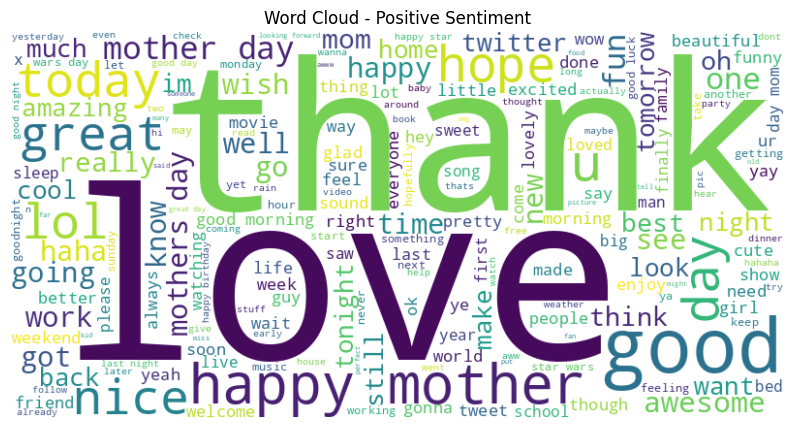

In [31]:
# Extract the text from positive sentiment tweets
positive_tweets = tweets_data[tweets_data["sentiment"] == "positive"]["cleaned_text"]

# Concatenate all the positive sentiment tweets into a single string
positive_text = " ".join(positive_tweets)

# Create a WordCloud object
wordcloud = WordCloud(width = 800, height = 400, background_color = "white").generate(positive_text)

# Plot the WordCloud
plt.figure(figsize = (10, 6))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.title("Word Cloud - Positive Sentiment")
plt.show()

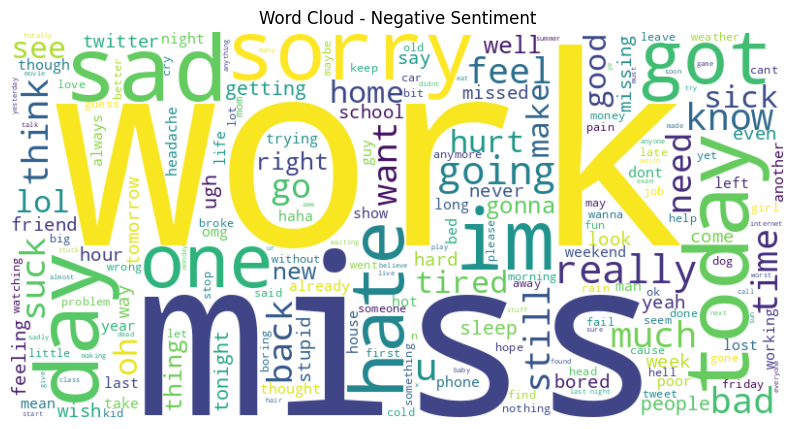

In [32]:
# Extract the text from negative sentiment tweets
negative_tweets = tweets_data[tweets_data["sentiment"] == "negative"]["cleaned_text"]

# Concatenate all the negative sentiment tweets into a single string
negative_text = " ".join(negative_tweets)

# Create a WordCloud object
wordcloud = WordCloud(width = 800, height = 400, background_color = "white").generate(negative_text)

# Plot the WordCloud
plt.figure(figsize = (10, 6))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.title("Word Cloud - Negative Sentiment")
plt.show()

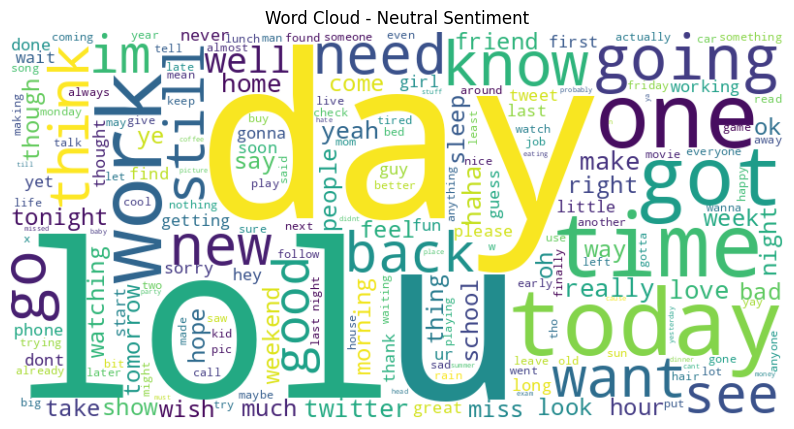

In [33]:
# Extract the text from neutral sentiment tweets
neutral_tweets = tweets_data[tweets_data["sentiment"] == "neutral"]["cleaned_text"]

# Concatenate all the neutral sentiment tweets into a single string
neutral_tweets = " ".join(neutral_tweets)

# Create a WordCloud object
wordcloud = WordCloud(width = 800, height = 400, background_color = "white").generate(neutral_tweets)

# Plot the WordCloud
plt.figure(figsize = (10, 6))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.title("Word Cloud - Neutral Sentiment")
plt.show()

Converting text labels to numeric form

In [34]:
tweets_data["sentiment"] = tweets_data["sentiment"].replace({"negative": 0, "neutral": 1, "positive": 2})

tweets_data.sample(10)

,text,sentiment,word_count,cleaned_text
1395,alhamdulilah. i got accepted into nafa,1,6,alhamdulilah got accepted nafa
16468,is still pretty depressed about losing her hel...,0,10,still pretty depressed losing hello kitty nec...
26978,morning all will be at Warner soon! lots to ...,2,25,morning warner soon lots go school work hope ...
209,thanks. before the major chop.,1,6,thanks major chop
5261,Ohhhh man My mom got a bag of these caramel c...,2,26,ohhhh man mom got bag caramel candy things so...
17315,_lu Just one part of a very odd trip. You trav...,1,21,lu one part odd trip travel months see weirdne...
19869,"Yep, I do.",1,4,yep
23693,the there`s confuse me,0,5,confuse
24170,don`t you hate it when you finish all your wor...,0,19,hate finish work still hours left work time
3460,You too sweetie,2,4,sweetie


StratifiedKFold is a variation of k-fold which returns stratified folds: each set contains approximately the same percentage of samples of each target class as the complete set.

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(tweets_data, test_size = 0.2, stratify = tweets_data["sentiment"], random_state = 123)
X_train, X_val = train_test_split(X_train, test_size = 0.1, stratify = X_train["sentiment"], random_state = 123)

X_train.shape, X_val.shape, X_test.shape

((19785, 4), (2199, 4), (5496, 4))

In [36]:
X_train["sentiment"].value_counts()

,count
sentiment,
1,8005
2,6178
0,5602


In [37]:
X_val["sentiment"].value_counts()

,count
sentiment,
1,889
2,687
0,623


In [38]:
X_test["sentiment"].value_counts()

,count
sentiment,
1,2223
2,1717
0,1556


Creating Training and validation dataset from corresponding pandas dataframes

In [39]:
raw_train_ds = tf.data.Dataset.from_tensor_slices(
    (X_train["text"].values, X_train["sentiment"].values)).shuffle(1024).batch(batch_size = 128)

raw_val_ds = tf.data.Dataset.from_tensor_slices(
    (X_val["text"].values, X_val["sentiment"].values)).batch(batch_size = 128)

raw_test_ds = tf.data.Dataset.from_tensor_slices(
    (X_test["text"].values, X_test["sentiment"].values)).batch(batch_size = 128)

len(raw_train_ds), len(raw_val_ds), len(raw_test_ds)

(155, 18, 43)

Taking a simple example of small corpus, we are showing how count vectorizer works

In [40]:
vocab_size = 30

count_vectorizer = layers.TextVectorization(
    standardize = "lower_and_strip_punctuation",
    max_tokens = vocab_size,
    output_mode = "count",
)

In [41]:
# list of text documents
text = ["Malcolm is an amazing painter. Malcolm also loves watching cricket",
        "Dean cooks well",
        "Malcolm is a decent footballer too",
        "Chris is a teacher, he is quite experienced in teaching"]

Next, we are  calling adapt to fit the state of the preprocessing layer to the dataset. This will cause the model to build an index of strings to integers.

In [42]:
count_vectorizer.adapt(text)

In [43]:
count_vectorizer.get_vocabulary()

['[UNK]',
 'is',
 'malcolm',
 'a',
 'well',
 'watching',
 'too',
 'teaching',
 'teacher',
 'quite',
 'painter',
 'loves',
 'in',
 'he',
 'footballer',
 'experienced',
 'decent',
 'dean',
 'cricket',
 'cooks',
 'chris',
 'an',
 'amazing',
 'also']

Malcolm appearing twice in first doc.

In [44]:
count_vectorizer(text)

<tf.Tensor: shape=(4, 24), dtype=int64, numpy=
array([[0, 1, 2, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        1, 1],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
        0, 0],
       [0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        0, 0],
       [0, 2, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0,
        0, 0]])>

Next, we will create a TextVectorization layer. You will use this layer to standardize, tokenize, and vectorize our data. You set the output_mode to count (Outputs a single int array per batch, of either vocab_size or max_tokens size,the int array contains a count of the number of times the token at that index appeared in the batch item.).

Note that you"re using the default split function, and the custom standardization function we defined above.

https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization

In [45]:
vocab_size = 10000

count_vectorizer = layers.TextVectorization(
    standardize = custom_standardization,
    max_tokens = vocab_size,
    output_mode = "count",
    ngrams = (1, 2)
)

Next, we will call adapt to fit the state of the preprocessing layer to the dataset. This will cause the model to build an index of strings to integers.

In [46]:
# Make a text-only dataset (without labels), then call adapt

train_text = raw_train_ds.map(lambda x, y: x)

count_vectorizer.adapt(train_text)

Creating a function to see the result of using this layer to preprocess some data.

In [47]:
def vectorize_text(text, label):
    # Shape () => (1, )
    text = tf.expand_dims(text, -1)

    return count_vectorizer(text), label

Extracting  a batch of tweets and labels from the dataset and displaying an instance with tweet , label and output of applying text vectorizer to the tweet

In [48]:
import sys
np.set_printoptions(threshold = sys.maxsize)

class_names = ["negative", "neutral", "positive"]
text_batch, label_batch = next(iter(raw_train_ds))
first_tweet, first_label = text_batch[0], label_batch[0]

print("Tweet: ", first_tweet)
print("Sentiment: ", class_names[first_label])
print("Vectorized review: ", vectorize_text(first_tweet, first_label))

Tweet:  tf.Tensor(b"Haha! just overheard on the us. 3 yrold to mom 'mom, I think I should learn to read today'", shape=(), dtype=string)
Sentiment:  neutral
Vectorized review:  (<tf.Tensor: shape=(1, 10000), dtype=int64, numpy=
array([[10,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 

In [49]:
count_vectorizer.get_vocabulary()

['[UNK]',
 'day',
 'good',
 'get',
 'like',
 'go',
 'today',
 'love',
 'going',
 'work',
 'got',
 'one',
 'time',
 'lol',
 'know',
 'happy',
 'u',
 'really',
 'back',
 'im',
 'see',
 'night',
 'new',
 'home',
 'think',
 'want',
 'well',
 'oh',
 'much',
 'still',
 'thanks',
 'miss',
 'great',
 'last',
 'need',
 'morning',
 'haha',
 'hope',
 'would',
 'feel',
 'fun',
 'tomorrow',
 'sorry',
 'twitter',
 'wish',
 'bad',
 'make',
 'tonight',
 'sad',
 'right',
 'week',
 'yeah',
 'nice',
 'way',
 'mother',
 'gonna',
 'though',
 'better',
 'sleep',
 'could',
 'weekend',
 'come',
 'next',
 'people',
 'bed',
 'getting',
 'mothers',
 'wait',
 'watching',
 'mother day',
 'hate',
 'days',
 'say',
 'awesome',
 'thing',
 'school',
 'dont',
 'even',
 'mom',
 'soon',
 'yes',
 'long',
 'little',
 'show',
 'best',
 'working',
 'sure',
 'never',
 'ok',
 'thank',
 'done',
 'mothers day',
 'tired',
 'hey',
 'cool',
 'feeling',
 'take',
 'cant',
 'happy mother',
 'everyone',
 'look',
 'first',
 'please',
 'l

In [50]:
vocab_size =  len(count_vectorizer.get_vocabulary())

vocab_size

10000

Checking some instances of vocabulary

In [51]:
print("40   ---> ", count_vectorizer.get_vocabulary()[40])
print("80   ---> ", count_vectorizer.get_vocabulary()[80])
print("160  ---> ", count_vectorizer.get_vocabulary()[160])

40   --->  fun
80   --->  yes
160  --->  someone


Before training our model, As a final preprocessing step, we will apply the TextVectorization layer we created earlier to the train, validation, and test dataset.

In [52]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

These are two important methods you should use when loading data to make sure that I/O does not become blocking.

.cache() keeps data in memory after it"s loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files. The tf.data.Dataset.cache transformation can cache a dataset, either in memory or on local storage. This will save some operations (like file opening and data reading) from being executed during each epoch.

.prefetch() The tf.data API provides the tf.data.Dataset.prefetch transformation. It can be used to decouple the time when data is produced from the time when data is consumed. In particular, the transformation uses a background thread and an internal buffer to prefetch elements from the input dataset ahead of the time they are requested. The number of elements to prefetch should be equal to (or possibly greater than) the number of batches consumed by a single training step. You could either manually tune this value, or set it to tf.data.AUTOTUNE, which will prompt the tf.data runtime to tune the value dynamically at runtime.

In [53]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

Model is defined which is simple Dense Neural network

In [54]:
dnn_model = Sequential([
    layers.Dense(64, activation = "tanh"),
    layers.Dropout(0.1),
    layers.Dense(32, activation = "tanh"),
    layers.Dropout(0.1),
    layers.Dense(3)
])

Model is compiled and summary is obtained. As activation=softmax is not defined inside the final dense layer we have to set logits=True

from_logits:Whether y_pred is expected to be a logits tensor. By default, we assume that y_pred encodes a probability distribution.

In [55]:
dnn_model.compile(
    loss = losses.SparseCategoricalCrossentropy(from_logits = True),
    optimizer = optimizers.Adam(learning_rate = 0.0001),
    metrics = ["accuracy"]
)

input_shape = (None, 10000)

dnn_model.build(input_shape)

dnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │         640,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 642,243 (2.45 MB)

 Trainable params: 642,243 (2.45 MB)

 Non-trainable params: 0 (0.00 B)

Model is trained for 10 epochs

In [56]:
history = dnn_model.fit(
    train_ds,
    epochs = 10,
    validation_data = val_ds)

Epoch 1/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 24s 128ms/step - accuracy: 0.4253 - loss: 1.0822 - val_accuracy: 0.5016 - val_loss: 1.0297
Epoch 2/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5507 - loss: 1.0017 - val_accuracy: 0.5884 - val_loss: 0.9492
Epoch 3/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6527 - loss: 0.8970 - val_accuracy: 0.6471 - val_loss: 0.8712
Epoch 4/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7072 - loss: 0.7935 - val_accuracy: 0.6676 - val_loss: 0.8151
Epoch 5/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7407 - loss: 0.7096 - val_accuracy: 0.6776 - val_loss: 0.7819
Epoch 6/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7678 - loss: 0.6421 - val_accuracy: 0.6830 - val_loss: 0.7658
Epoch 7/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7866 - loss: 0.5898 - val_accuracy: 0.6858 - val_loss: 0.7607
Epoch 8/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8034 - loss: 0.5470 - val_accuracy:

Loss and accuracy is evaluated on test data

In [57]:
loss, accuracy = dnn_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 0.6772 - loss: 0.7859
Loss:  0.7999109625816345
Accuracy:  0.6783115267753601


Accuracy and Loss are plotted wrt epochs

In [58]:
history_dict = history.history

history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [59]:
history_dict

{'accuracy': [0.45630529522895813,
  0.5711397528648376,
  0.6601465940475464,
  0.7077078819274902,
  0.7389436364173889,
  0.7653778195381165,
  0.7854435443878174,
  0.8024260997772217,
  0.8177407383918762,
  0.8323982954025269],
 'loss': [1.0675355195999146,
  0.9822330474853516,
  0.8767968416213989,
  0.7790105938911438,
  0.7002410888671875,
  0.6357467770576477,
  0.5855149030685425,
  0.5431883931159973,
  0.506049633026123,
  0.4724367558956146],
 'val_accuracy': [0.5015916228294373,
  0.5884492993354797,
  0.6471123099327087,
  0.6675761938095093,
  0.677580714225769,
  0.6830377578735352,
  0.6857662796974182,
  0.6903137564659119,
  0.6898590326309204,
  0.6921327710151672],
 'val_loss': [1.0296826362609863,
  0.9491511583328247,
  0.8712489604949951,
  0.8151484727859497,
  0.7819367051124573,
  0.7658398747444153,
  0.7607094645500183,
  0.7638469338417053,
  0.7731324434280396,
  0.7866953015327454]}

Model is overfitting after 7th epoch

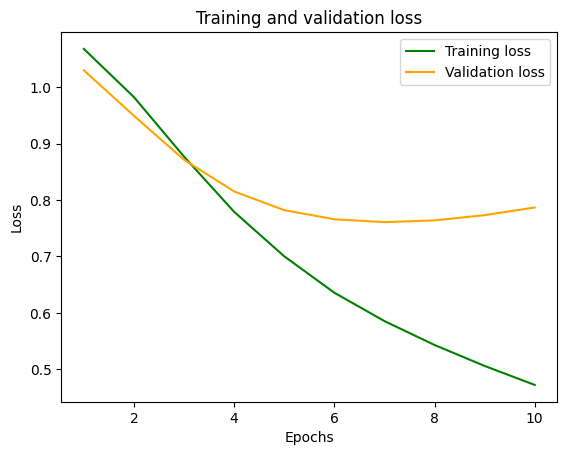

In [60]:
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, color = "green", label = "Training loss")

plt.plot(epochs, val_loss, color = "orange", label = "Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

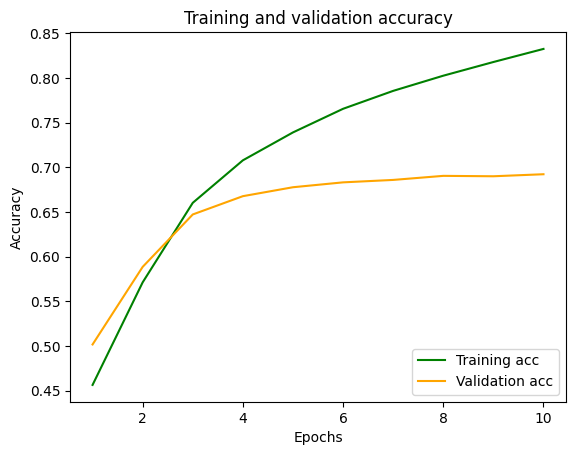

In [61]:
plt.plot(epochs, acc, color = "green", label = "Training acc")
plt.plot(epochs, val_acc, color = "orange", label = "Validation acc")

plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc = "lower right")

plt.show()

In the training code above, we applied the TextVectorization layer to the dataset before feeding text to the model. If we want to make our  model capable of processing raw strings (for example, to simplify deploying it), you can include the TextVectorization layer inside your model. To do so, you can create a new model using the weights you just trained.

In [63]:
export_model = Sequential([
  count_vectorizer,
  dnn_model
])

export_model.compile(
    loss = losses.SparseCategoricalCrossentropy(from_logits = True),
    optimizer = optimizers.Adam(learning_rate = 0.0001),
    metrics = ["accuracy"]
)


Cross verifying obtained metrics using sklearn. Recall is bit lower for Negative class(0.61)

In [64]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,\
                            classification_report

predictions = export_model.predict(X_test["text"].values)

y_pred = np.argmax(predictions , axis = 1)
y_test = X_test["sentiment"]

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average = None)
precision = precision_score(y_test, y_pred, average = None)
recall = recall_score(y_test, y_pred, average = None)

# Get the classification report
report = classification_report(y_test,y_pred)

# Print the classification report
print(report)

172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
              precision    recall  f1-score   support

           0       0.69      0.60      0.64      1556
           1       0.63      0.71      0.67      2223
           2       0.75      0.71      0.73      1717

    accuracy                           0.68      5496
   macro avg       0.69      0.67      0.68      5496
weighted avg       0.68      0.68      0.68      5496



Now we are using TF-IDF Vectorizer instead of Count vectorizer

Taking a simple corpus

In [65]:
vocab_size = 30

tfidf_vectorizer = layers.TextVectorization(
    standardize = "lower_and_strip_punctuation",
    max_tokens = vocab_size,
    output_mode = "tf-idf",
)

In [66]:
text = ["Malcolm is an amazing painter. Malcolm also loves watching cricket",
        "Dean cooks well",
        "Malcolm is a decent footballer too",
        "Chris is a teacher, he is quite experienced in teaching"]

In [67]:
tfidf_vectorizer.adapt(text)

In [68]:
tfidf_vectorizer.get_vocabulary()

['[UNK]',
 'is',
 'malcolm',
 'a',
 'well',
 'watching',
 'too',
 'teaching',
 'teacher',
 'quite',
 'painter',
 'loves',
 'in',
 'he',
 'footballer',
 'experienced',
 'decent',
 'dean',
 'cricket',
 'cooks',
 'chris',
 'an',
 'amazing',
 'also']

tf idf scores can be seen for each word in vocabulary for each document

In [69]:
tfidf_vectorizer(text)

<tf.Tensor: shape=(4, 24), dtype=float32, numpy=
array([[0.        , 0.6931472 , 1.6945957 , 0.        , 0.        ,
        1.0986123 , 0.        , 0.        , 0.        , 0.        ,
        1.0986123 , 1.0986123 , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 1.0986123 , 0.        ,
        0.        , 1.0986123 , 1.0986123 , 1.0986123 ],
       [0.        , 0.        , 0.        , 0.        , 1.0986123 ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.0986123 , 0.        , 1.0986123 ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.6931472 , 0.84729785, 0.84729785, 0.        ,
        0.        , 1.0986123 , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 1.0986123 ,
        0.        , 1.0986123 , 0.        , 0.        , 0.        ,
        0.        , 0

Now we are defining our tfidf vectorizer with parameters. Note here we are taking ngrams in range (1,2)

In [70]:
vocab_size = 10000

tfidf_vectorizer = layers.TextVectorization(
    standardize = custom_standardization,
    max_tokens = vocab_size,
    output_mode = "tf-idf",
    ngrams = (1, 2)
)

tfidf_vectorizer.adapt(train_text)

Checking the entire vocabulary

In [71]:
tfidf_vectorizer.get_vocabulary()

['[UNK]',
 'day',
 'good',
 'get',
 'like',
 'go',
 'today',
 'love',
 'going',
 'work',
 'got',
 'one',
 'time',
 'lol',
 'know',
 'happy',
 'u',
 'really',
 'back',
 'im',
 'see',
 'night',
 'new',
 'home',
 'think',
 'want',
 'well',
 'oh',
 'much',
 'still',
 'thanks',
 'miss',
 'great',
 'last',
 'need',
 'morning',
 'haha',
 'hope',
 'would',
 'feel',
 'fun',
 'tomorrow',
 'sorry',
 'twitter',
 'wish',
 'bad',
 'make',
 'tonight',
 'sad',
 'right',
 'week',
 'yeah',
 'nice',
 'way',
 'mother',
 'gonna',
 'though',
 'better',
 'sleep',
 'could',
 'weekend',
 'come',
 'next',
 'people',
 'bed',
 'getting',
 'mothers',
 'wait',
 'watching',
 'mother day',
 'hate',
 'days',
 'say',
 'awesome',
 'thing',
 'school',
 'dont',
 'even',
 'mom',
 'soon',
 'yes',
 'long',
 'little',
 'show',
 'best',
 'working',
 'sure',
 'never',
 'ok',
 'thank',
 'done',
 'mothers day',
 'tired',
 'hey',
 'cool',
 'feeling',
 'take',
 'cant',
 'happy mother',
 'everyone',
 'look',
 'first',
 'please',
 'l

Creating a function to see the result of using this tfidf vectorizer layer to preprocess some data.

In [72]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return tfidf_vectorizer(text), label

Before training our model, As a final preprocessing step, we will apply the TextVectorization layer we created earlier to the train, validation, and test dataset.

In [73]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

These are two important methods you should use when loading data to make sure that I/O does not become blocking.

.cache() keeps data in memory after it"s loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

.prefetch() overlaps data preprocessing and model execution while training.

In [74]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

Here same DNN is used but learning rate is decreased and model is trained for longer epochs(40)

In [75]:
dnn_model = Sequential([
    layers.Dense(64, activation = "tanh"),
    layers.Dropout(0.1),
    layers.Dense(32, activation = "tanh"),
    layers.Dropout(0.1),
    layers.Dense(3)
])

dnn_model.compile(
    loss = losses.SparseCategoricalCrossentropy(from_logits = True),
    optimizer = optimizers.Adam(learning_rate = 0.00001),
    metrics = ["accuracy"]
)

history = dnn_model.fit(
    train_ds,
    epochs = 40,
    validation_data = val_ds
)

Epoch 1/40
155/155 ━━━━━━━━━━━━━━━━━━━━ 25s 143ms/step - accuracy: 0.3172 - loss: 1.2344 - val_accuracy: 0.3492 - val_loss: 1.1153
Epoch 2/40
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3565 - loss: 1.1331 - val_accuracy: 0.4175 - val_loss: 1.0706
Epoch 3/40
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3990 - loss: 1.0922 - val_accuracy: 0.4548 - val_loss: 1.0503
Epoch 4/40
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4327 - loss: 1.0692 - val_accuracy: 0.4943 - val_loss: 1.0342
Epoch 5/40
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4646 - loss: 1.0445 - val_accuracy: 0.5152 - val_loss: 1.0187
Epoch 6/40
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4926 - loss: 1.0248 - val_accuracy: 0.5348 - val_loss: 1.0032
Epoch 7/40
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5126 - loss: 1.0004 - val_accuracy: 0.5480 - val_loss: 0.9879
Epoch 8/40
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5342 - loss: 0.9833 - val_accuracy:

Performance on test data has decreased from previous model with count vectorizer.

In [76]:
loss, accuracy = dnn_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.6722 - loss: 0.7802
Loss:  0.7917659878730774
Accuracy:  0.6661208271980286


Accuracy and Loss are plotted wrt epochs. Model is underfitting

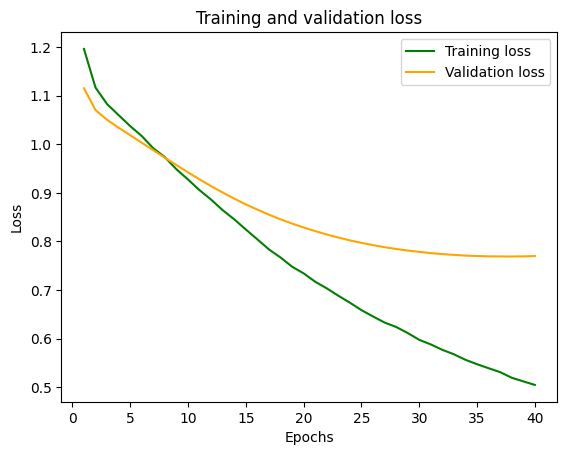

In [77]:
history_dict = history.history
history_dict.keys()

acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, color = "green", label = "Training loss")

plt.plot(epochs, val_loss, color = "orange", label = "Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

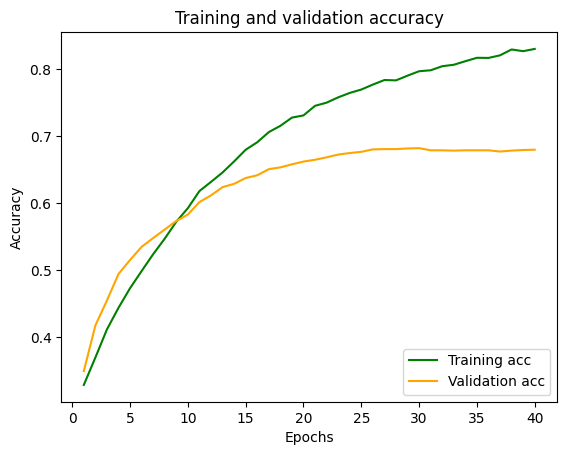

In [78]:
plt.plot(epochs, acc, color = "green", label = "Training acc")
plt.plot(epochs, val_acc, color = "orange", label = "Validation acc")

plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc = "lower right")

plt.show()

In [80]:
export_model = Sequential([
  tfidf_vectorizer,
  dnn_model
])

export_model.compile(
    loss = losses.SparseCategoricalCrossentropy(from_logits = True),
    optimizer = optimizers.Adam(learning_rate = 0.00001),
    metrics = ["accuracy"]
)


Defining a vectorized layer for training using Embedding layer. Steps will be repeated here too

"int": Outputs integer indices, one integer index per split string token. When output_mode == "int", 0 is reserved for masked locations; this reduces the vocab size to max_tokens - 2 instead of max_tokens - 1.

"output_sequence_length": Only valid in INT mode. If set, the output will have its time dimension padded or truncated to exactly output_sequence_length values, resulting in a tensor of shape (batch_size, output_sequence_length) regardless of how many tokens resulted from the splitting step. Defaults to None.

https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization

In [81]:
vocab_size = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize = custom_standardization,
    max_tokens = vocab_size,
    output_mode = "int",
    output_sequence_length = sequence_length
)

In [82]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [83]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

Before training our model, As a final preprocessing step, we will apply the TextVectorization layer you created earlier to the train, validation, and test dataset.

In [84]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

These are two important methods you should use when loading data to make sure that I/O does not become blocking.

.cache() keeps data in memory after it"s loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

.prefetch() overlaps data preprocessing and model execution while training.

You can learn more about both methods, as well as how to cache data to disk in the data performance guide.

In [85]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

We are using a callback list here

Early stopping — Interrupting training when the validation loss is no longer improving (and save the best model obtained during training).
ReduceLROnPlateau-Dynamically adjusting the value of certain parameters during training such as the learning rate optimizer.
Tensorboard-Logging training and validation metrics during training or visualizing representations learned by the model as they’re updated. (The Keras progress bar we always see in our terminal during training!)

Callbacks are passed to the during via the callback argument in the fit() method which takes a list of callbacks. Any number of callbacks can be passed to it.

The monitor argument in the EarlyStopping callback monitor’s the model’s validation accuracy and the patience argument interrupts training when the parameter passed to the monitor argument stops improving for more than the number (of epochs) passed to it (in this case 3).

Also, the ReduceLROnPlateau callback is used to reduce the learning rate when the validation loss has stopped improving. This has proven to be a very effective strategy to get out of local minima during training. The factor argument takes as input a float which is used to multipy the learning rate when triggered.Factor by which the learning rate will be reduced. new_lr = lr * factor.

In [86]:
callback_list = [
    keras.callbacks.EarlyStopping(
        patience = 3,
        monitor = "val_accuracy"
    ),

    keras.callbacks.ReduceLROnPlateau(
        patience = 1,
        factor = 0.1,
    )
]

Neural network creation is started

The layers are stacked sequentially to build the classifier:

The first layer is an Embedding layer. This layer takes the integer-encoded reviews and looks up an embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: (batch, sequence, embedding). To learn more about embeddings, check out the Word embeddings tutorial.
Next, a GlobalAveragePooling1D layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.
The last layer is densely connected with a triple output node as there are 3 labels.

#### Embeddings
Word embeddings give us a way to use an efficient, dense representation in which similar words have a similar encoding. Importantly, you do not have to specify this encoding by hand. An embedding is a dense vector of floating point values (the length of the vector is a parameter you specify). Instead of specifying the values for the embedding manually, they are trainable parameters (weights learned by the model during training, in the same way a model learns weights for a dense layer). It is common to see word embeddings that are 8-dimensional (for small datasets), up to 1024-dimensions when working with large datasets. A higher dimensional embedding can capture fine-grained relationships between words, but takes more data to learn.

#### GlobalAveragePooling1D

After passing through the embedding layer, you have a 3D tensor of shape (batch_size, sequence_length, embedding_dimension). GlobalAveragePooling1D compresses or reduces this 3D tensor into a 2D tensor. It does this by averaging over the sequence dimension (sequence_length), resulting in a 2D tensor of shape (batch_size, embedding_dimension). Essentially, it calculates the average of each embedding dimension across all words in the sequence.

Reduces Dimensionality: It simplifies the model by reducing the number of parameters, helping to mitigate overfitting.
Handles Variable Length Input: Useful in dealing with sentences of varying lengths, as it averages over the entire sequence length.
Captures Global Features: By averaging, it captures the essence of the entire input sequence, making it effective for tasks like document classification where the overall sentiment or theme is more important than the individual elements.

In [87]:
embedding_dim = 64

model = Sequential([
  layers.Embedding(input_dim = vocab_size, output_dim = embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dense(64, activation = "tanh"),
  layers.Dropout(0.1),
  layers.Dense(32, activation = "tanh"),
  layers.Dropout(0.1),
  layers.Dense(3)]
)

model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Note that the validation accuracy stalls and the learning rate is reduced by a factor of 10 (multiplied by 0.1)

In [88]:
model.compile(optimizer = optimizers.Adam(learning_rate = 0.001),
               loss = losses.SparseCategoricalCrossentropy(from_logits = True),
               metrics = ["accuracy"])

history = model.fit(
    train_ds,
    epochs = 50,
    validation_data = val_ds,
    callbacks = callback_list
)

Epoch 1/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.3995 - loss: 1.0894 - val_accuracy: 0.4043 - val_loss: 1.0865 - learning_rate: 0.0010
Epoch 2/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4033 - loss: 1.0878 - val_accuracy: 0.4043 - val_loss: 1.0856 - learning_rate: 0.0010
Epoch 3/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4017 - loss: 1.0868 - val_accuracy: 0.4047 - val_loss: 1.0790 - learning_rate: 0.0010
Epoch 4/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4121 - loss: 1.0784 - val_accuracy: 0.4234 - val_loss: 1.0573 - learning_rate: 0.0010
Epoch 5/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4292 - loss: 1.0578 - val_accuracy: 0.4707 - val_loss: 1.0039 - learning_rate: 0.0010
Epoch 6/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4824 - loss: 1.0209 - val_accuracy: 0.4056 - val_loss: 1.0000 - learning_rate: 0.0010
Epoch 7/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4719 - loss: 1.0279 -

Peformance is slighly better than Model with TF_IDF vectorizer and is close to Model with Count vectorizer

In [89]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6650 - loss: 0.7978
Loss:  0.8102630972862244
Accuracy:  0.6661208271980286


Accuracy and Loss are plotted wrt epochs. Model is overfitting

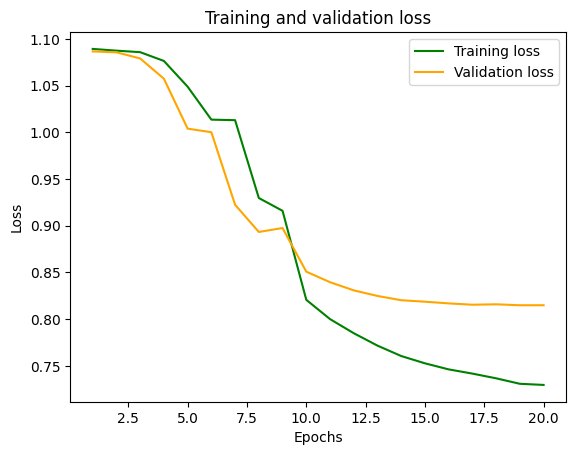

In [90]:
history_dict = history.history
history_dict.keys()

acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

epochs = range(1, len(acc) + 1)


plt.plot(epochs, loss, color = "green", label = "Training loss")

plt.plot(epochs, val_loss, color = "orange", label = "Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

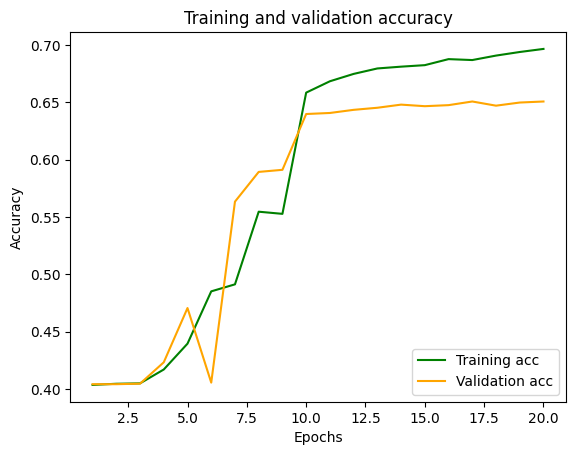

In [91]:
plt.plot(epochs, acc, color = "green", label = "Training acc")
plt.plot(epochs, val_acc, color = "orange", label = "Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc = "lower right")

plt.show()

Now we will be training a more advanced neural network with RNNs. Steps will be repeated here too

We will train a simple RNN model.Model is overfitting after 3 epochs.Note that final layer has softmax activation defined so  the setting is "from_logits = False".

In [92]:
embedding_dim = 128

rnn_model = Sequential()

rnn_model.add(layers.Embedding(input_dim = vocab_size, output_dim = embedding_dim))

rnn_model.add(layers.SimpleRNN(128, return_sequences = True))

rnn_model.add(layers.GlobalMaxPool1D())

rnn_model.add(layers.Dense(3, activation = "softmax"))

rnn_model.compile(optimizer = optimizers.Adam(learning_rate = 0.001),
               loss = losses.SparseCategoricalCrossentropy(from_logits = False),
               metrics = ["accuracy"])

history = rnn_model.fit(
    train_ds,
    epochs = 20,
    validation_data = val_ds, callbacks = callback_list)

Epoch 1/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - accuracy: 0.4362 - loss: 1.0528 - val_accuracy: 0.6294 - val_loss: 0.8206 - learning_rate: 0.0010
Epoch 2/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.7043 - loss: 0.7181 - val_accuracy: 0.6862 - val_loss: 0.7434 - learning_rate: 0.0010
Epoch 3/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.7979 - loss: 0.5296 - val_accuracy: 0.6730 - val_loss: 0.7929 - learning_rate: 0.0010
Epoch 4/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.8697 - loss: 0.3881 - val_accuracy: 0.6839 - val_loss: 0.7979 - learning_rate: 1.0000e-04
Epoch 5/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8807 - loss: 0.3561 - val_accuracy: 0.6862 - val_loss: 0.7966 - learning_rate: 1.0000e-05


In [93]:
loss, accuracy = rnn_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.6748 - loss: 0.8096
Loss:  0.8171893358230591
Accuracy:  0.6754003167152405


Simple LSTM model is trained . Performance is marginally higher than our Count vectorizer +DNN model.

In [94]:
embedding_dim = 128

lstm_model = Sequential()

lstm_model.add(layers.Embedding(input_dim = vocab_size, output_dim = embedding_dim))

lstm_model.add(layers.SpatialDropout1D(0.25))

lstm_model.add(layers.LSTM(128, dropout = 0.6, return_sequences = True))

lstm_model.add(layers.GlobalMaxPooling1D())

lstm_model.add(layers.Dense(32, activation = "tanh"))
lstm_model.add(layers.Dense(3, activation = "softmax"))

lstm_model.compile(optimizer = optimizers.Adam(learning_rate = 0.001),
               loss = losses.SparseCategoricalCrossentropy(from_logits = False),
               metrics = ["accuracy"])

history = lstm_model.fit(
    train_ds,
    epochs = 20,
    validation_data = val_ds, callbacks = callback_list)

Epoch 1/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.4516 - loss: 1.0421 - val_accuracy: 0.6576 - val_loss: 0.7793 - learning_rate: 0.0010
Epoch 2/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6894 - loss: 0.7421 - val_accuracy: 0.6917 - val_loss: 0.7342 - learning_rate: 0.0010
Epoch 3/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7425 - loss: 0.6367 - val_accuracy: 0.6999 - val_loss: 0.7466 - learning_rate: 0.0010
Epoch 4/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.7874 - loss: 0.5549 - val_accuracy: 0.7012 - val_loss: 0.7545 - learning_rate: 1.0000e-04
Epoch 5/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.7938 - loss: 0.5406 - val_accuracy: 0.7058 - val_loss: 0.7453 - learning_rate: 1.0000e-05
Epoch 6/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.7938 - loss: 0.5423 - val_accuracy: 0.7062 - val_loss: 0.7378 - learning_rate: 1.0000e-06
Epoch 7/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.790

In [95]:
loss, accuracy = lstm_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6959 - loss: 0.7619
Loss:  0.7646732926368713
Accuracy:  0.697780191898346


Accuracy score and Losses are shown wrt epochs. Model overfitting after 3 epochs

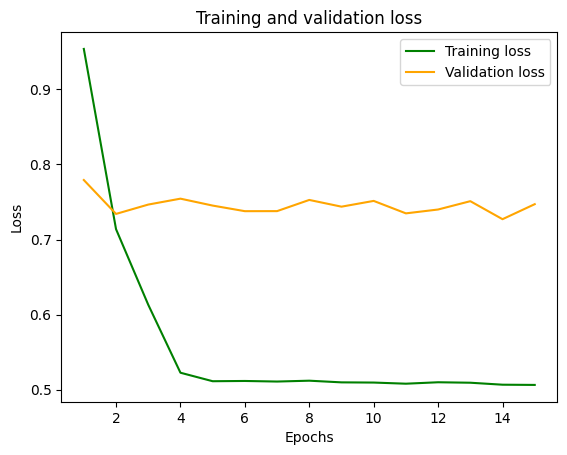

In [96]:
history_dict = history.history
history_dict.keys()

acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

epochs = range(1, len(acc) + 1)


plt.plot(epochs, loss, color = "green", label = "Training loss")

plt.plot(epochs, val_loss, color = "orange", label = "Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

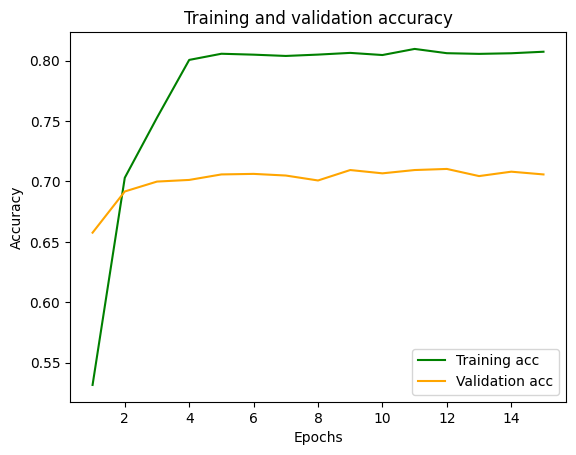

In [97]:
plt.plot(epochs, acc, color = "green", label = "Training acc")
plt.plot(epochs, val_acc, color = "orange", label = "Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc = "lower right")

plt.show()

In [99]:
export_model = Sequential([
  vectorize_layer,
  lstm_model
])

export_model.compile(
    loss = losses.SparseCategoricalCrossentropy(from_logits = False),
    optimizer = optimizers.Adam(learning_rate = 0.001),
    metrics = ["accuracy"]
)



We are doing inferencing on some examples and model predicting spam quite well. Note that keras3.0 does not work here

In [101]:
examples = [
  "this experience has been the worst, want my money back",
  "this AI related article is very good",
  "The movie was average" ]
examples = tf.convert_to_tensor(examples)
export_model.predict(examples)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


array([[0.9787375 , 0.01974846, 0.00151405],
       [0.02740143, 0.15428889, 0.81830966],
       [0.64006746, 0.32605344, 0.0338791 ]], dtype=float32)

As we have already defined.."negative": 0, "neutral": 1, "positive": 2. So predictions makes sense

In [102]:
np.argmax(export_model.predict(examples), axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


array([0, 2, 1])

Cross verifying metrics  with scikit-learn .
Recall for negative class seems to have improved . f1 score and accuracy improved for each class from our Count vectorizer+DNN model

In [103]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,\
                            classification_report

predictions = export_model.predict(X_test["text"].values)
y_pred = np.argmax(predictions , axis = 1)

y_test = X_test["sentiment"]
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average = None)
precision = precision_score(y_test,y_pred, average = None)
recall = recall_score(y_test,y_pred, average = None)

# Get the classification report
report = classification_report(y_test,y_pred)

# Print the classification report
print(report)

172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
              precision    recall  f1-score   support

           0       0.73      0.63      0.68      1556
           1       0.65      0.72      0.68      2223
           2       0.75      0.73      0.74      1717

    accuracy                           0.70      5496
   macro avg       0.71      0.69      0.70      5496
weighted avg       0.70      0.70      0.70      5496



Saving the trained model

In [104]:
lstm_model.save("sentiment_predictor.keras")

Loading the saved model and checking its performance

In [105]:
# Loading the saved model
loaded_model = models.load_model("sentiment_predictor.keras")
loss, accuracy = loaded_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6948 - loss: 0.7662
Loss:  0.760309636592865
Accuracy:  0.698326051235199
